# Машинное обучение

## Факультет математики НИУ ВШЭ

### 2019-2020 учебный год

Илья Щуров, Соня Дымченко, Руслан Хайдуров, Александр Каган, Павел Балтабаев

# Семинар 15 (16)
---

# K-means

<img src="http://dendroid.sk/wp-content/uploads/2013/01/kmeansimg-scaled1000.jpg" width=400>

Алгоритм k-means применяется для задачи кластеризации. Напомню его основные шаги. Пусть у нас имеется $N$ точек на плоскости ${(x_1,y_1),...,(x_N,y_N)}$
Допустим мы хотим разбить их на $k=2$ кластера.
1. Выбираем $k=2$ случайные точки из этого множества. Говорим, что они являются теперь центрами наших кластеров.
2. Для каждой из оставшихся точек смотрим, к какому из центров она ближе и определяем её в этот кластер.
3. У нас получилось разбить точки на 3 кластера. Естественно это не оптимальное разбиение. Найдём новые центры кластеров. Например, если точки ${(x_{i_1}, y_{i_1}),...,(x_{i_n}, y_{i_n})}$ попали в один кластер, то их новый центр будет имеет координаты:
$$x_M=\frac{x_{i_1}+...+x_{i_n}}{n}$$
$$y_M=\frac{y_{i_1}+...+y_{i_n}}{n}$$
4. Переходим к шагу 2 и продолжаем до тех пор, пока кластеры не перестанут меняться.

[Ссылка на визуализацию](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/)

In [1]:
from sklearn.cluster import DBSCAN
DBSCAN?

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles

np.random.seed(42)

plt.figure(figsize=(16, 5))

X_noised, y_noised = make_blobs(n_samples=1500, centers=3, cluster_std=2.1, random_state=42)
plt.subplot(131)
plt.scatter(X_noised[:, 0], X_noised[:, 1], edgecolors='face')
plt.axis('equal') # чтобы рисунок был не растянут
plt.title(u"Круглые кластеры", fontsize=15)

transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]] # матрица преобразования
X_long = np.dot(X_noised, transformation) # умножим на нее, чтобы растянуть кучки
y_long = y_noised

plt.subplot(132)
plt.scatter(X_long[:, 0], X_long[:, 1], edgecolors='face')
plt.title(u"Вытянутые кластеры", fontsize=15)

X_circles, y_circles = make_circles(n_samples=1500, factor=0.5, noise=0.05)
plt.subplot(133)
plt.scatter(X_circles[:, 0], X_circles[:, 1], edgecolors='face')
plt.title(u"Кластеры сложной структуры", fontsize=15)

plt.show()

<Figure size 1600x500 with 3 Axes>

In [3]:
logging = dict(blob=[], long=[], circle=[])

In [4]:
ys = [y_noised, y_long, y_circles]

### K-means из sklearn

Воспользуйтесь реализацией алгоритма из библиотеки sklearn и провизуализируйте результат кластеризации на $k=2,3,5,7$ классов для трех датасетов выше, сохраните результат, провизуализируйте (получится сетка графиков 4 на 3)

In [5]:
k = [2, 3, 5, 7]
Xs = [X_noised, X_long, X_circles]

In [6]:
from sklearn.cluster import KMeans
KMeans?

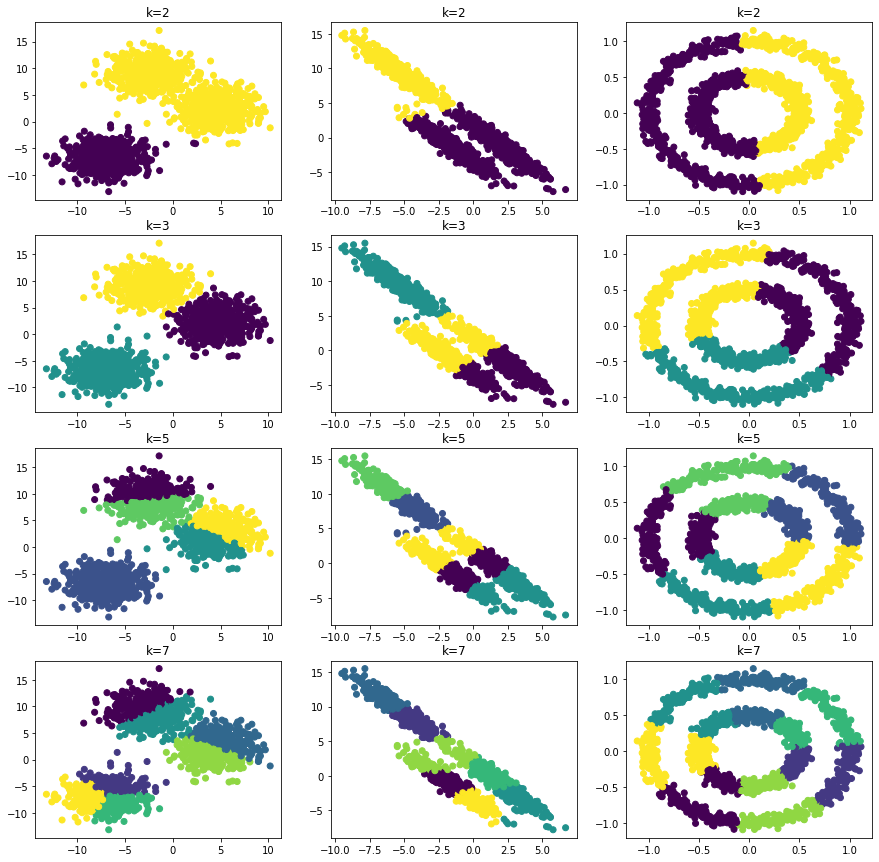

In [7]:
plt.figure(figsize=(15, 15))
i=1
for k_cl in k:
    for data, name in zip(Xs, list(logging.keys())):
        cluster = KMeans(n_clusters=k_cl)
        labels = cluster.fit(data).labels_
        logging[name].append((f'KMeans_{k_cl}', labels))
        plt.subplot(4,3,i)
        plt.title(f'k={k_cl}')
        plt.scatter(data[:,0], data[:,1], c=labels)
        i+=1
plt.show()

# Спектральная кластеризация

Состоит из 3х шагов:

1. Для входных данных размерностью $(N, d)$ считаем матрицу схожести $A$ размерностью $(N,N)$. В простейшем случае это могут быть попарные расстояния, но на самом деле матрица может быть получена и с использованием более сложных операций над парами точек 
2. Полученная матрица симметрична. Вычисляем для нее матрицу Лапласиана:
    $${\displaystyle L=D-A}$$
    где ${\displaystyle D}$  диагональная матрица, такая что:
    $${\displaystyle D_{ii}=\sum _{j}A_{ij}.}$$
    В самом алгоритме используется нормализованная версия Лапласиана
3. Подсчет собственных векторов для матрицы Лапласиана и кластеризация этих векторов подручными методами, например, с помощью того же K-means

In [8]:
import scipy as sp
from sklearn.metrics import pairwise_distances


def laplacian(A):
    """Computes the symetric normalized laplacian.
    L = D^{-1/2} A D^{-1/2}
    """
    D = np.zeros(A.shape)
    w = np.sum(A, axis=0)
    D.flat[::len(w) + 1] = w ** (-0.5)  # set the diag of D to w
    return D.dot(A).dot(D)


def k_means(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1231)
    return kmeans.fit(X).labels_


def spectral_clustering(affinity, n_clusters, cluster_method=k_means):
    L = laplacian(affinity)
    eig_val, eig_vect = sp.sparse.linalg.eigs(L, n_clusters)
    X = eig_vect.real
    rows_norm = np.linalg.norm(X, axis=1, ord=2)
    Y = (X.T / rows_norm).T
    labels = cluster_method(Y, n_clusters)
    return labels

In [9]:
A = pairwise_distances(X_noised)
A.shape

(1500, 1500)

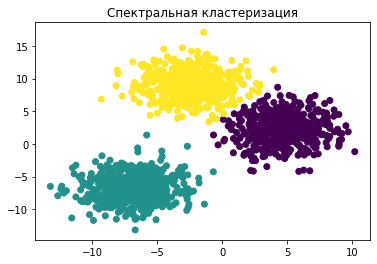

In [10]:
labels = spectral_clustering(A, n_clusters=3)
points_x = X_noised[:,0]
points_y = X_noised[:,1]
plt.title('Спектральная кластеризация')
plt.scatter(x=points_x, y=points_y, c=labels)
plt.show()

### Спектральная кластеризация из sklearn

Сделайте кластеризацию с помощью sklearn для тех же трех датасетов с числом кластеров $k=2,3,5,7$, сохраните результат, провизуализируйте.

In [11]:
from sklearn.cluster import SpectralClustering

SpectralClustering?

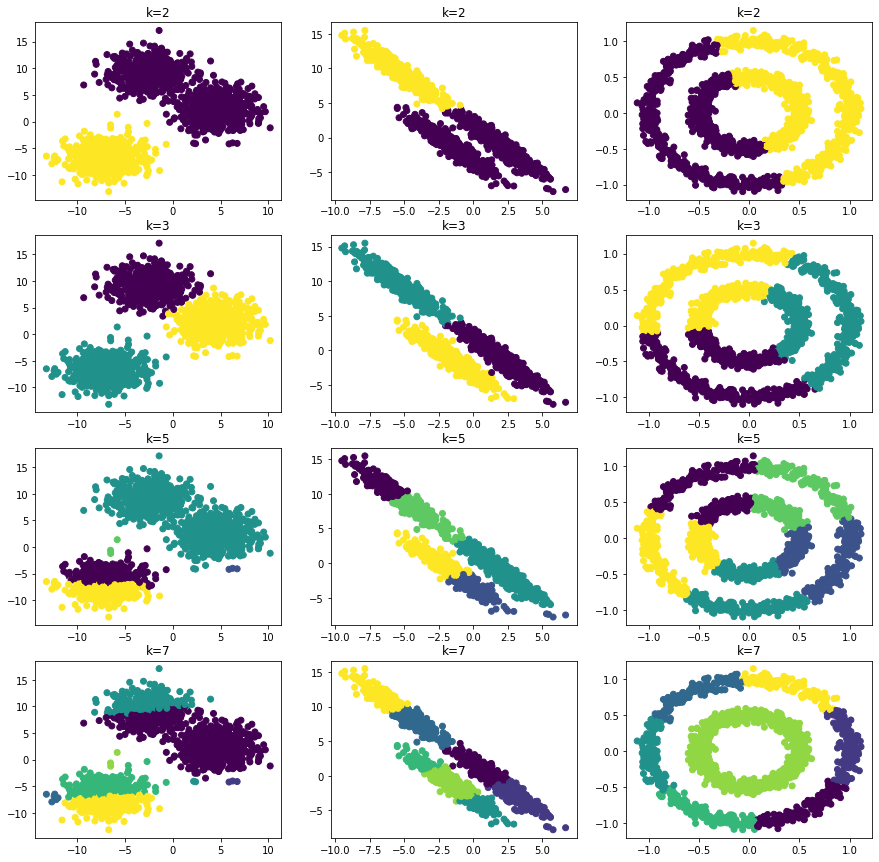

In [12]:
plt.figure(figsize=(15, 15))
i=1
for k_cl in k:
    for data, name in zip(Xs, list(logging.keys())):
        cluster = SpectralClustering(n_clusters=k_cl, n_jobs=-1)
        labels = cluster.fit(data).labels_
        logging[name].append((f'Spec_{k_cl}', labels))
        plt.subplot(4,3,i)
        plt.title(f'k={k_cl}')
        plt.scatter(data[:,0], data[:,1], c=labels)
        i+=1
plt.show()

# Агломеративная кластеризация

Наверное самый простой и понятный алгоритм кластеризации без фиксированного числа кластеров — агломеративная кластеризация.

Интуиция у алгоритма очень простая:

1. Начинаем с того, что высыпаем на каждую точку свой кластер
2. Сортируем попарные расстояния между центрами кластеров по возрастанию
3. Берём пару ближайших кластеров, склеиваем их в один и пересчитываем центр кластера
4. Повторяем п. 2 и 3 до тех пор, пока все данные не склеятся в один кластер

Сам процесс поиска ближайших кластеров может происходить с использованием разных методов объединения точек:

* Single linkage — минимум попарных расстояний между точками из двух кластеров
* Complete linkage — максимум попарных расстояний между точками из двух кластеров
* Average linkage — среднее попарных расстояний между точками из двух кластеров
* Centroid linkage — расстояние между центроидами двух кластеров


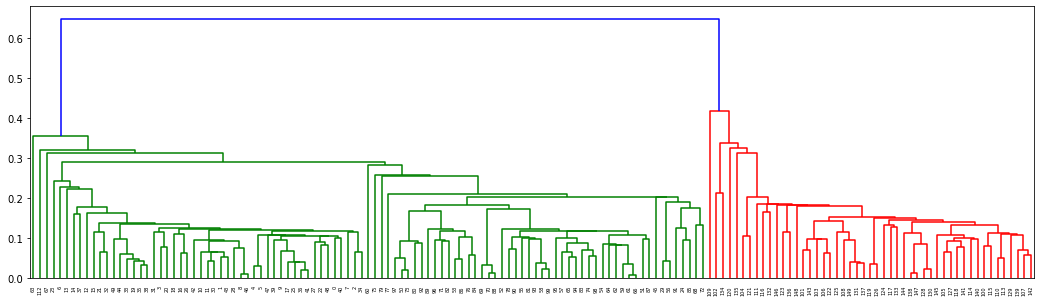

In [13]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

X[50:100, 0] = np.random.normal(loc=-1.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

distance_mat = pdist(X) # pdist посчитает нам верхний треугольник матрицы попарных расстояний

Z = hierarchy.linkage(distance_mat, 'single') # linkage — реализация агломеративного алгоритма
plt.figure(figsize=(18, 5))
dn = hierarchy.dendrogram(Z, color_threshold=0.5)

In [14]:
hierarchy.cut_tree?

### Аггломеративная кластеризация из sklearn
С помощью sklearn сделаем аггломеративную кластеризацию с числом кластеров $k=3,10$ для разных параметров.

In [15]:
import time

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

In [16]:
kneighbors_graph?

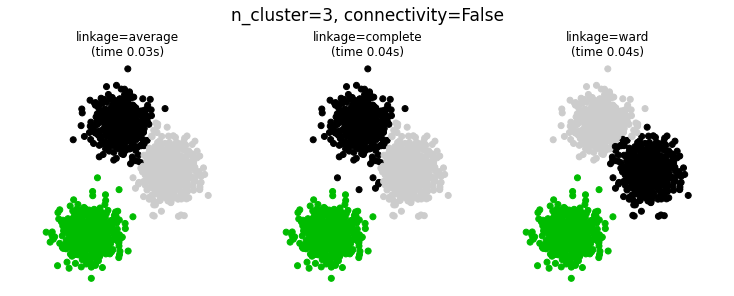

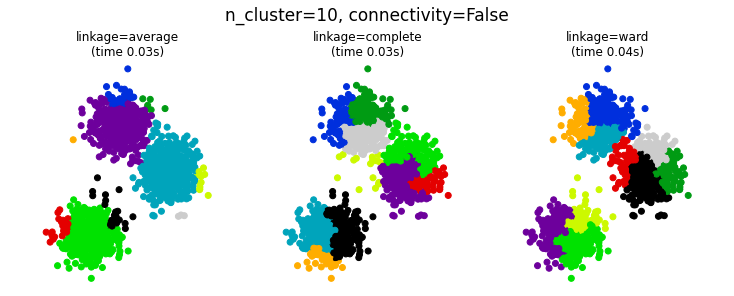

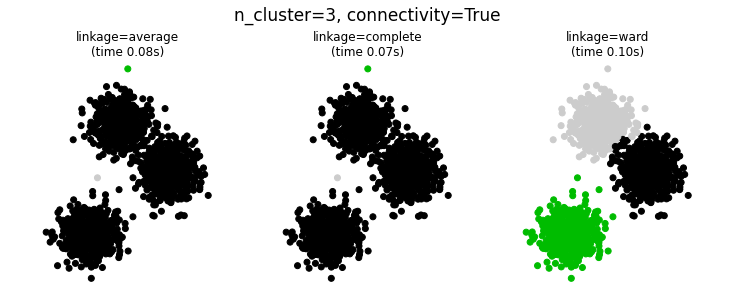

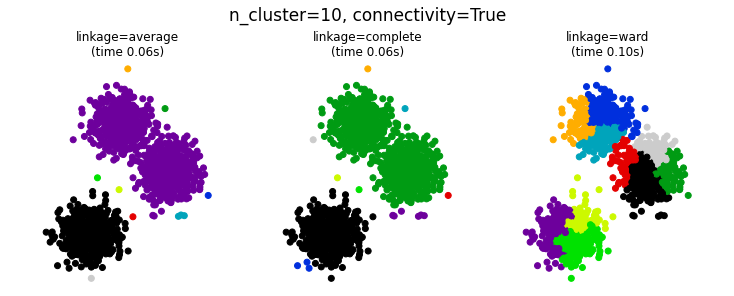

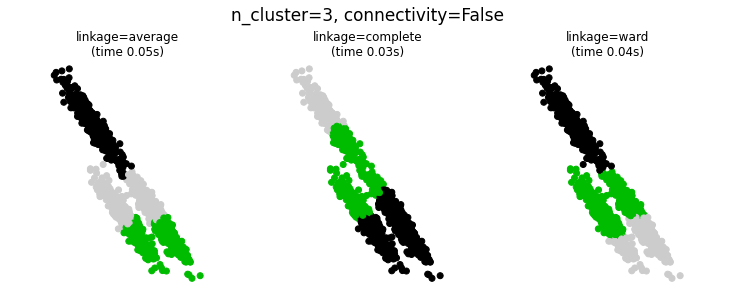

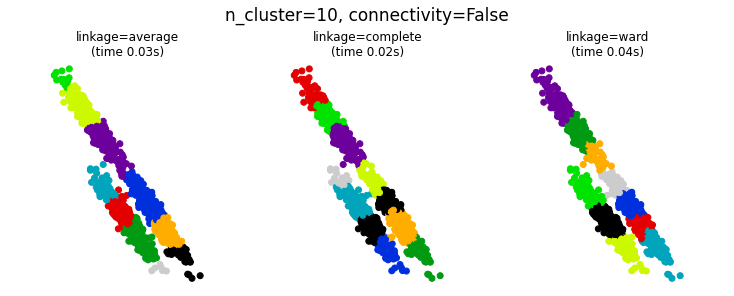

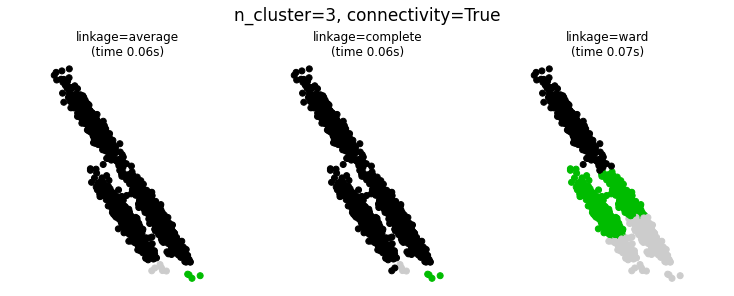

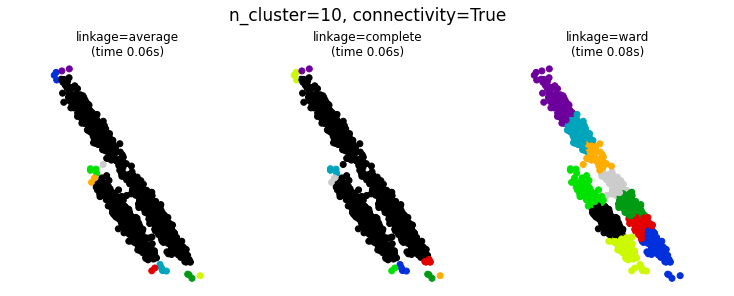

/home/svdcvt/.local/lib/python3.6/site-packages/sklearn/cluster/_agglomerative.py:478: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)
/home/svdcvt/.local/lib/python3.6/site-packages/sklearn/cluster/_agglomerative.py:478: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)
/home/svdcvt/.local/lib/python3.6/site-packages/sklearn/cluster/_agglomerative.py:245: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')
/home/svdcvt/.local/lib/python3.6/site-packages/sklearn/cluster/_agglomerative.py:478: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)
/home/svdcvt/.local/lib/python3.6

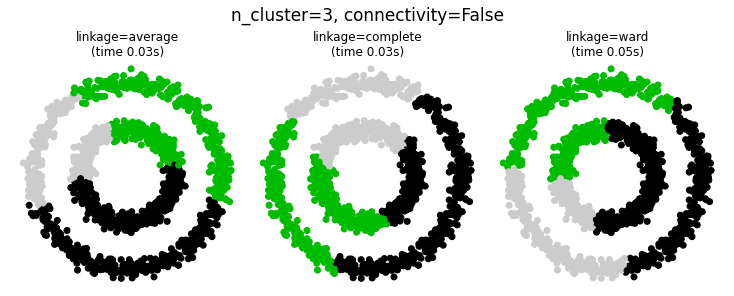

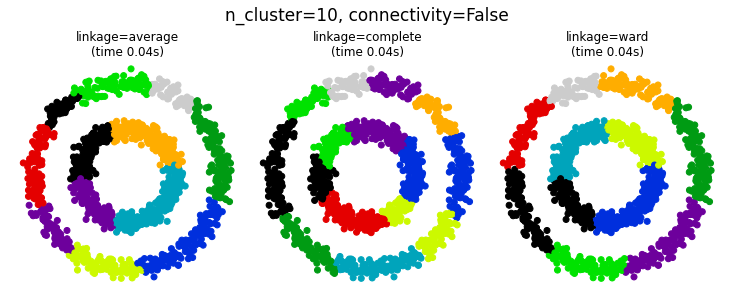

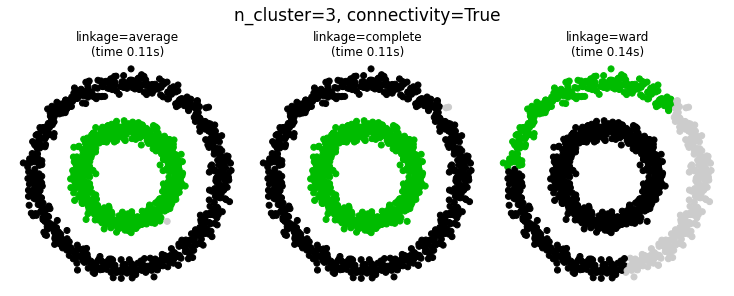

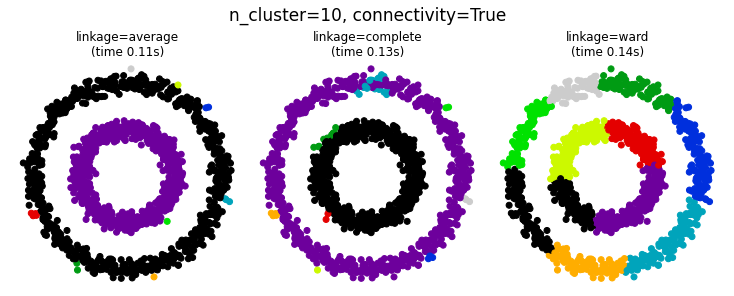

In [17]:
for data, name in zip(Xs, list(logging.keys())):

    knn_graph = kneighbors_graph(data, 10, include_self=False)

    for connectivity in (None, knn_graph):
        for n_clusters in (3, 10):
            plt.figure(figsize=(10, 4))
            for index, linkage in enumerate(('average',
                                             'complete',
                                             'ward')):
                plt.subplot(1, 3, index + 1)
                model = AgglomerativeClustering(linkage=linkage,
                                                connectivity=connectivity,
                                                n_clusters=n_clusters)
                t0 = time.time()
                model.fit(data)
                
                logging[name].append((f'AggCl_{n_clusters}_{linkage[:3]}_{"con" if connectivity is not None else ""}', model.labels_))
                elapsed_time = time.time() - t0
                plt.scatter(data[:, 0], data[:, 1], c=model.labels_,
                            cmap=plt.cm.nipy_spectral)
                plt.title('linkage=%s\n(time %.2fs)' % (linkage, elapsed_time),
                          fontdict=dict(verticalalignment='top'))
                plt.axis('equal')
                plt.axis('off')

                plt.subplots_adjust(bottom=0, top=0.8, wspace=0,
                                    left=0, right=1)
                plt.suptitle('n_cluster=%i, connectivity=%r' %
                             (n_clusters, connectivity is not None), size=17)


    plt.show()

# Метрики кластеризации

### Adjusted Rand Index (ARI)

Как можно догадаться по названию, это "подкрученная" метрика `Random Index`:

${\displaystyle RI(S)={\frac {a+b}{a+b+c+d}}={\frac {a+b}{n \choose 2}}}$

Для набора $S$ из $n$ элементов и его двух возможных разбиений на кластера  $X$ и $Y$

* $  a$, количество пар элементов в $  S$, которые находятся в одном и том же подмножестве в  $X$ и в одном и том же подмножестве в $  Y$
* $b$, количество пар элементов в $S$, которые находятся в разных подмножествах в $ X$ и в разных подмножествах в $  Y$

* $  c$, количество пар элементов в $ S$, которые находятся в одном и том же подмножестве в $  X$ и в разных подмножествах в $  Y$
* $  d$, количество пар элементов в $ S$, которые находятся в разных подмножествах в $  X$ и в одном и том же подмножестве в $  Y$

 Метрика $ARI$ делает поправку на то, чтобы случайное разметка $S$ на кластера имела бы метрику равной нулю.

$${\displaystyle \overbrace {ARI} ^{\text{Adjusted Index}}={\frac {\overbrace {\sum _{ij}{\binom {n_{ij}}{2}}} ^{\text{Index}}-\overbrace {[\sum _{i}{\binom {a_{i}}{2}}\sum _{j}{\binom {b_{j}}{2}}]/{\binom {n}{2}}} ^{\text{Expected Index}}}{\underbrace {{\frac {1}{2}}[\sum _{i}{\binom {a_{i}}{2}}+\sum _{j}{\binom {b_{j}}{2}}]} _{\text{Max Index}}-\underbrace {[\sum _{i}{\binom {a_{i}}{2}}\sum _{j}{\binom {b_{j}}{2}}]/{\binom {n}{2}}} _{\text{Expected Index}}}}}$$

In [18]:
from sklearn.metrics import adjusted_rand_score


# Silhouette

Если вдруг все же надо подобрать значение k достаточно хорошим, можно смотреть на визуализацию метрики силуэт.

Для ее подсчета не требуется знать истинную разметку, она лишь характеризует текущую.

Wiki:
>Let ${\displaystyle b(i)} $ be the smallest average distance of ${\displaystyle i}$  to all points in any other cluster, of which ${\displaystyle i}$  is not a member. The cluster with this smallest average dissimilarity is said to be the "neighbouring cluster" of ${\displaystyle i}$  because it is the next best fit cluster for point ${\displaystyle i}$. We now define a silhouette:

$${\displaystyle s(i)={\frac {b(i)-a(i)}{\max\{a(i),b(i)\}}}}$$

Таким образом, чем выше ситуэт для объекта, тем глубже этот объект находится в своем кластере.

Это также может помочь детектировать выбросы в данных.

Пример визуализации:
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Silhouette-plot-orange.png/800px-Silhouette-plot-orange.png" width=400>

[Пример подбора параметра K для Kmeans с помощью `Silhouette`](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

In [19]:
from sklearn.metrics import silhouette_score
from skimage.metrics import structural_similarity

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.68457533009059
For n_clusters = 3 The average silhouette_score is : 0.4698484422736942
For n_clusters = 4 The average silhouette_score is : 0.40808405778169093
For n_clusters = 5 The average silhouette_score is : 0.4079222932280724
For n_clusters = 6 The average silhouette_score is : 0.4698349790722241


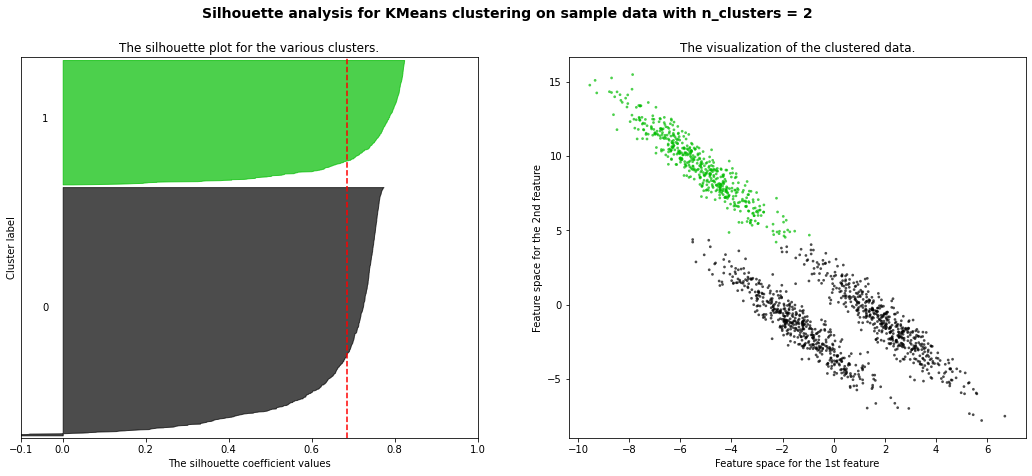

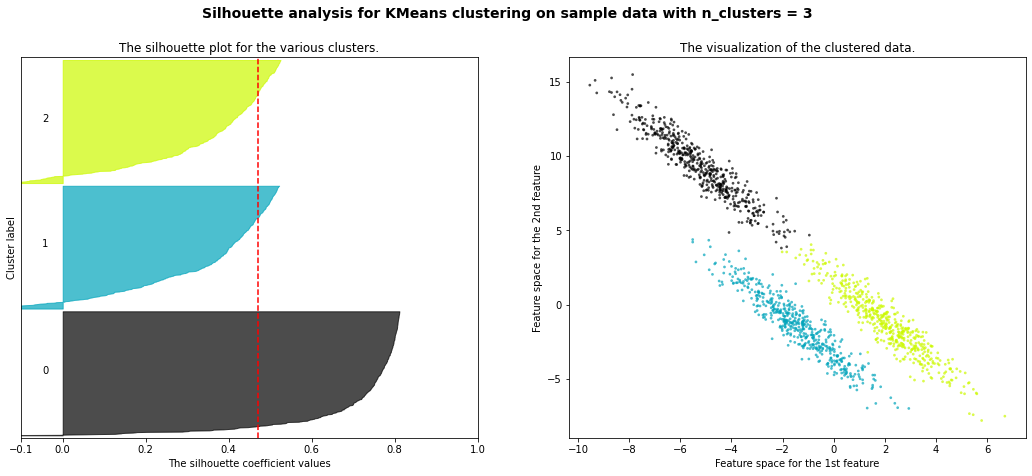

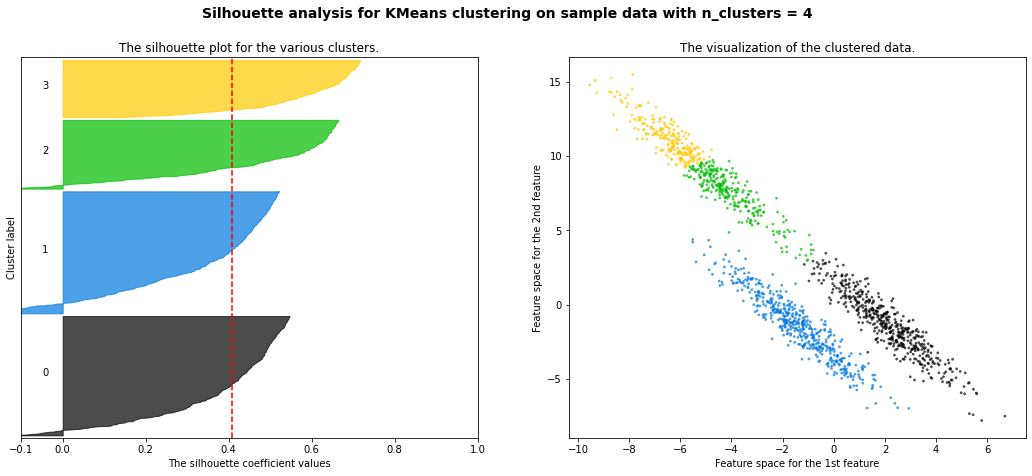

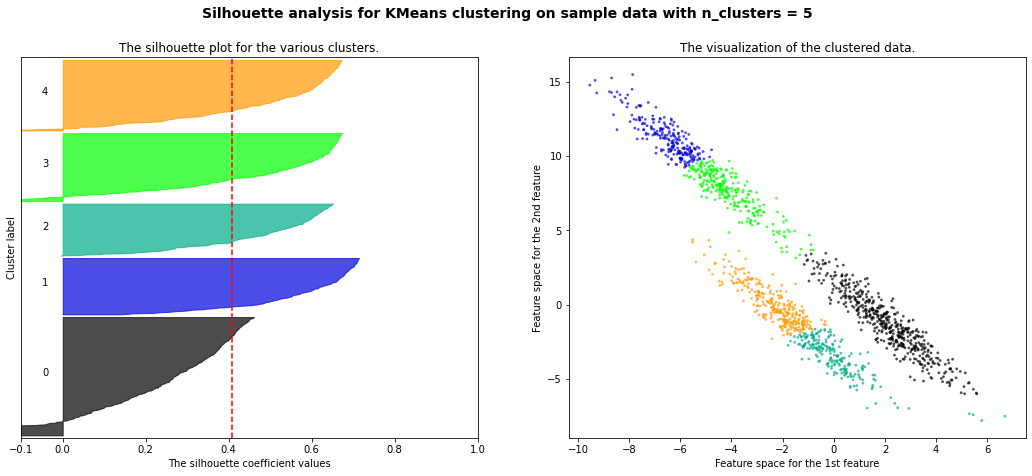

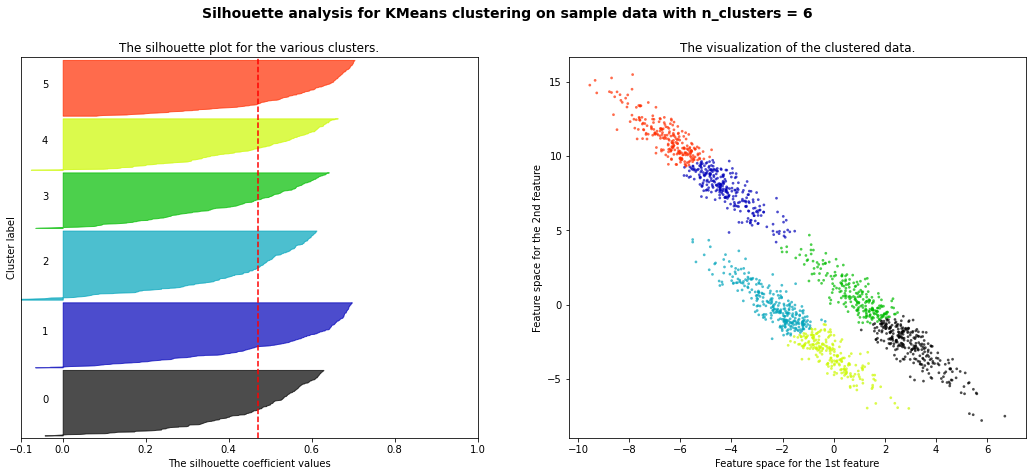

In [21]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = X_long, y_long
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = SpectralClustering(n_clusters=n_clusters, n_jobs=-1)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

#     # Labeling the clusters
#     centers = clusterer.cluster_centers_
#     # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#                 c="white", alpha=1, s=200, edgecolor='k')

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### Посчитаем метрики
Посчитайте метрику ARI для всех использованных вами алгоритмов кластеризации для датасетов.

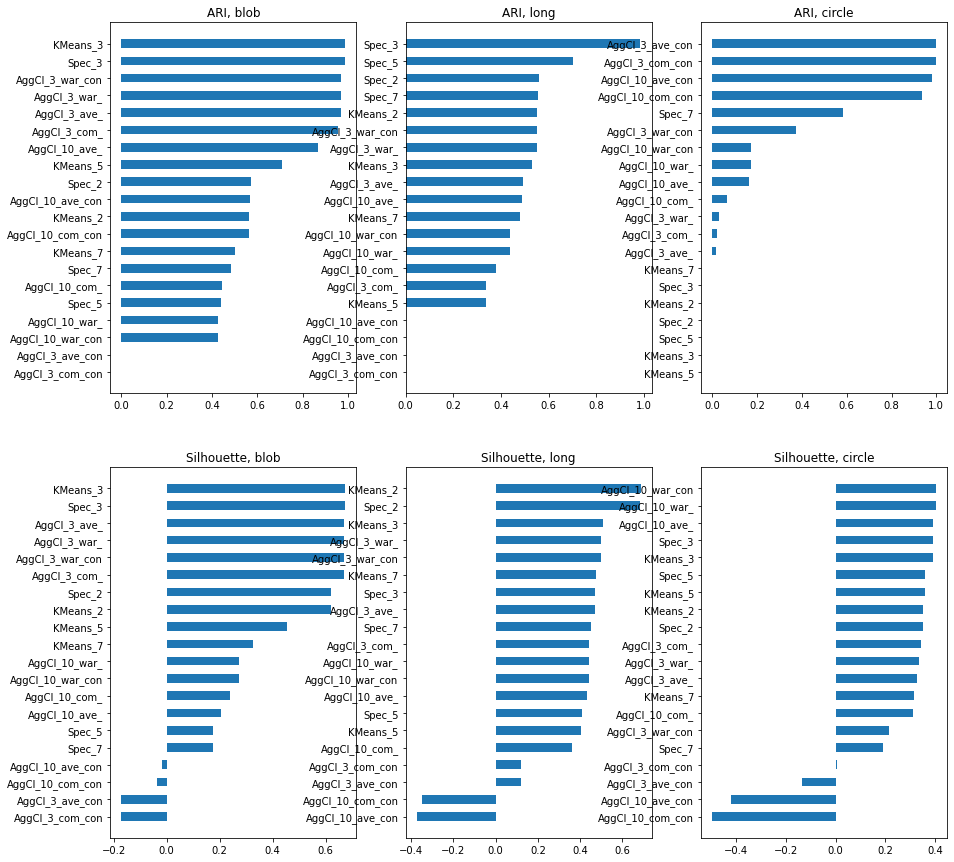

In [30]:
plt.figure(figsize=(15,15))
i = 1
for metric in ['ARI', 'Silhouette']:
    for data, gt, name in zip(Xs, ys, logging.keys()):
        plt.subplot(2, 3, i)
        plt.title(f'{metric}, {name}')
        m = []
        algs = []
        for alg, labels in logging[name]:
            algs.append(alg)
            if metric == 'ARI':
                m.append(adjusted_rand_score(labels, gt))
            elif metric == 'Silhouette':
                m.append(silhouette_score(data, labels))
        m_sorted_id = np.argsort(m)
        plt.barh(np.array(algs)[m_sorted_id], np.array(m)[m_sorted_id], height=0.5)
        i += 1
plt.show()

# Кластеризация картинки

Найдите в интернете картинку, подгрузите ее и примените алгоритм кластеризации. 

Посмотрите что вышло.

image shape:  (300, 400, 3)


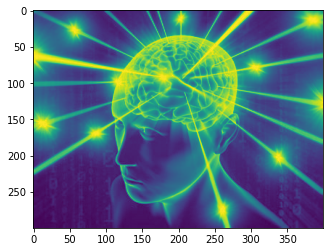

In [31]:
from PIL import Image
import urllib

def load_image(infilename):
    if infilename.startswith('https'):
        f = urllib.request.urlopen(infilename)
        img = Image.open(f)
    else:
        img = Image.open(infilename)
    img.load()
    data = np.asarray(img, dtype="float32")
    return data

def save_image(img,outfilename):
    img.save(outfilename)
    

url = 'https://blueseatblogs.com/wp-content/uploads/2018/07/consciousness-709143-400x300.jpg'# твоя ссылка тут # (つ▀¯▀)つ
pic = load_image(url)
print("image shape: ", pic.shape)
plt.imshow(pic[:,:,1])
plt.show()

Для картинки нужно уменьшить число цветов в палитре; для этого нужно выделить кластеры в пространстве RGB, объекты соответствуют пикселям изображения; после выделения кластеров, все пиксели, отнесенные в один кластер, заполняются одним цветом; этот цвет может быть центроидом соответствующего кластера, медианным цветом по кластеру. Попробуйте различные алгоритмы кластеризации:

* KMeans
* DBSCAN

Можно использовать и другие:
* MeanShift
* AgglomerativeClustering

Какие угодно, какие сможете найти. 
Рассмотрите число кластеров K = 2, 3, 10, 20 (в алгоритмах, где есть такой гиперпараметр).

Для различных кластеризаций оцените и сравните потери от уменьшения цветов при помощи метрики [SSIM](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_ssim). Какой способ оказался лучшим?

In [36]:
cl = KMeans(3, n_init=3, n_jobs=-1)
pic_rgb = pic.reshape(-1, 3)
cl.fit(pic_rgb)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=3, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

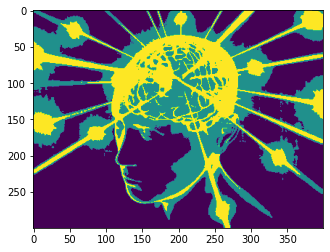

In [37]:
plt.imshow(cl.labels_.reshape(300, 400))

In [38]:
cl = DBSCAN(eps=0.5, n_jobs=-1)
pic_rgb = pic.reshape(-1, 3)
cl.fit(pic_rgb)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=-1, p=None)

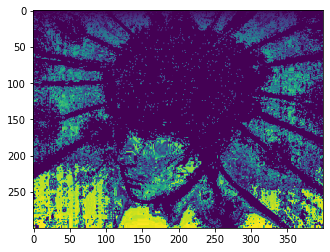

In [39]:
plt.imshow(cl.labels_.reshape(300, 400))